# Legitimate Overrides: Complete Paper Analysis Notebook

This notebook consolidates all analysis scripts for the Legitimate Overrides paper:
- **Figure Generation** (8 figures: lof01-lof08)
- **Sentiment Pipeline** (Forum + Twitter analysis)
- **Intervention Mechanism Calculator** (Stochastic cost model)
- **Analysis Markdown Generation**

---

## Configuration (Toggle Settings)

In [36]:
# ============================================================================
# CONFIGURATION TOGGLES
# ============================================================================

# Figure saving
SAVE_FIGURES = True           # Save figures to /paper/figures
SHOW_FIGURES_INLINE = True    # Display figures in notebook

# Analysis markdown
SAVE_ANALYSIS_MD = True       # Save analysis markdown to /paper/analysis

# Sentiment pipeline
RUN_SENTIMENT_FORUMS = True   # Run forum sentiment (Discourse)
RUN_SENTIMENT_TWITTER = True # Run Twitter sentiment (requires API key)
SAVE_SENTIMENT_DATA = True    # Save sentiment CSVs to /data/sentiment

# Calculator
USE_SENTIMENT_IN_CALC = True  # Use sentiment data in calculator

# Twitter API (hardcoded for reviewers' use)
TWITTER_BEARER_TOKEN="AAAAAAAAAAAAAAAAAAAAAGZD7AEAAAAARDCRky6oBQdhxS7EkWfclzjNRDk%3DhYXnaSbYfUbdbiqsFdMj8mBPI2dwUtyfhh1PFfOu2YYPyTYIHI"


# Paths
from pathlib import Path
DATA_DIR = Path('/Users/elemoghenekaro/Desktop/tasks/legitimate-overrides-paper/data')
FIGURES_DIR = Path('/Users/elemoghenekaro/Desktop/tasks/legitimate-overrides-paper/paper/figures')
ANALYSIS_DIR = Path('/Users/elemoghenekaro/Desktop/tasks/legitimate-overrides-paper/paper/analysis')
SENTIMENT_DIR = DATA_DIR / 'sentiment'

# Create directories
FIGURES_DIR.mkdir(exist_ok=True, parents=True)
ANALYSIS_DIR.mkdir(exist_ok=True, parents=True)
SENTIMENT_DIR.mkdir(exist_ok=True, parents=True)

print("Configuration loaded.")
print(f"  SAVE_FIGURES: {SAVE_FIGURES}")
print(f"  SAVE_ANALYSIS_MD: {SAVE_ANALYSIS_MD}")
print(f"  RUN_SENTIMENT_FORUMS: {RUN_SENTIMENT_FORUMS}")
print(f"  RUN_SENTIMENT_TWITTER: {RUN_SENTIMENT_TWITTER}")
print(f"  SAVE_SENTIMENT_DATA: {SAVE_SENTIMENT_DATA}")
print(f"  USE_SENTIMENT_IN_CALC: {USE_SENTIMENT_IN_CALC}")

Configuration loaded.
  SAVE_FIGURES: True
  SAVE_ANALYSIS_MD: True
  RUN_SENTIMENT_FORUMS: True
  RUN_SENTIMENT_TWITTER: True
  SAVE_SENTIMENT_DATA: True
  USE_SENTIMENT_IN_CALC: True


## Imports & Setup

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar
from datetime import datetime
from dataclasses import dataclass
from typing import List, Dict, Optional
import requests
import warnings
warnings.filterwarnings('ignore')

# VADER sentiment
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
    analyzer = SentimentIntensityAnalyzer()
    print("✓ VADER sentiment analyzer loaded")
except ImportError:
    VADER_AVAILABLE = False
    analyzer = None
    print("⚠ VADER not installed, using fallback scoring")

# Matplotlib config
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.family'] = 'sans-serif'

# Colors
COLORS = {
    'primary_blue': '#2563EB',
    'danger_red': '#DC2626',
    'success_green': '#16A34A',
    'warning_amber': '#D97706',
    'neutral_gray': '#6B7280',
    'purple': '#7C3AED',
    'light_blue': '#60A5FA',
    'light_gray': '#9CA3AF',
}
AUTHORITY_COLORS = {
    'Signer Set': COLORS['primary_blue'],
    'Delegated Body': COLORS['success_green'],
    'Governance': COLORS['purple'],
}
print("✓ Setup complete")

✓ VADER sentiment analyzer loaded
✓ Setup complete


## Data Loading

In [38]:
# Load datasets
exploits = pd.read_csv(DATA_DIR / 'lif_exploits_final.csv', parse_dates=['date'])
interventions = pd.read_csv(DATA_DIR / 'lif_all_interventions.csv', parse_dates=['date'])
metrics = pd.read_csv(DATA_DIR / 'lif_intervention_metrics.csv', parse_dates=['date'])

# Create filtered datasets
intervention_eligible = exploits[exploits['is_lif_relevant'] == True].copy()

# Split non-eligible into systemic vs other
systemic_failures = exploits[
    (exploits['is_lif_relevant'] == False) & 
    (exploits['vector_category'].fillna('').str.contains('Systemic|Economic', case=False))
].copy()

other_non_addressable = exploits[
    (exploits['is_lif_relevant'] == False) & 
    (~exploits['vector_category'].fillna('').str.contains('Systemic|Economic', case=False))
].copy()

technical_only = exploits[exploits['is_technical'] == True].copy()

print(f"✓ Loaded {len(exploits)} total exploits")
print(f"  - Intervention-eligible: {len(intervention_eligible)} cases (${intervention_eligible['loss_usd'].sum()/1e9:.2f}B)") # Technical exploits
print(f"  - Systemic Failures: {len(systemic_failures)} cases (${systemic_failures['loss_usd'].sum()/1e9:.2f}B)") # Systemic failures and economic collapses
print(f"  - Other Non-Addressable: {len(other_non_addressable)} cases (${other_non_addressable['loss_usd'].sum()/1e9:.2f}B)") # Rug pulls, phishing, etc.
print(f"  - Interventions (all): {len(interventions)} cases (${interventions['loss_usd'].sum()/1e9:.2f}B)")
print(f"  - Metrics (curated): {len(metrics)} cases (${metrics['loss_usd'].sum()/1e9:.2f}B)")

✓ Loaded 705 total exploits
  - Intervention-eligible: 601 cases ($9.60B)
  - Systemic Failures: 10 cases ($61.80B)
  - Other Non-Addressable: 94 cases ($7.41B)
  - Interventions (all): 130 cases ($7.51B)
  - Metrics (curated): 52 cases ($3.27B)


---
# Part 1: Sentiment Pipeline
---

In [43]:
@dataclass
class SentimentResult:
    incident_id: str
    source: str
    score: float
    label: str
    sample_size: int
    posts: List[Dict] = None

def get_sentiment_label(score: float) -> str:
    if score > 0.5: return "Strongly Supportive"
    if score > 0.1: return "Supportive"
    if score > -0.1: return "Neutral"
    if score > -0.5: return "Skeptical"
    return "Hostile"

def analyze_text(text: str) -> float:
    if analyzer:
        return analyzer.polarity_scores(text)['compound']
    return 0.0

def fetch_discourse_posts(forum_url: str, category: str = None, limit: int = 20) -> List[Dict]:
    """Fetch posts from a Discourse forum."""
    try:
        url = f"{forum_url}/latest.json"
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return []
        data = resp.json()
        posts = []
        for topic in data.get('topic_list', {}).get('topics', [])[:limit]:
            posts.append({
                'title': topic.get('title', ''),
                'created_at': topic.get('created_at'),
                'url': f"{forum_url}/t/{topic.get('slug')}/{topic.get('id')}"
            })
        return posts
    except Exception as e:
        print(f"  ⚠ Error fetching from {forum_url}: {e}")
        return []

# Forum configurations for key incidents
FORUM_CONFIGS = {
    'FLOW-2025-12': {'url': 'https://forum.flow.com', 'keywords': ['security', 'upgrade', 'recovery']},
    'LIQWID-2025-10': {'url': 'https://gov.liqwid.finance', 'keywords': ['pause', 'emergency']},
    'STAKEWISE-2025': {'url': 'https://forum.stakewise.io', 'keywords': ['recovery', 'multisig']},
    'ANCHOR-2022-05': {'url': 'https://forum.anchorprotocol.com', 'keywords': ['ust', 'collapse']},
    'GNOSIS-BALANCER-2025': {'url': 'https://forum.gnosis.io', 'keywords': ['balancer', 'hack', 'fork']},
    'SUI-2025-05': {'url': 'https://forum.sui.io', 'keywords': ['freeze', 'pause']},
    'AAVE-2025-05': {'url': 'https://governance.aave.com', 'keywords': ['freeze', 'pause']},
    'BNB-Chain-2022': {'url': 'https://forum.bnbchain.org', 'keywords': ['freeze', 'pause']},
}

print("✓ Sentiment pipeline functions defined")

✓ Sentiment pipeline functions defined


In [44]:
# Run Forum Sentiment Analysis
sentiment_results = []

def fetch_specific_topics(forum_url: str, topic_ids: list) -> List[Dict]:
    """Fetch specific topics by ID from a Discourse forum."""
    posts = []
    for topic_id in topic_ids:
        try:
            url = f"{forum_url}/t/{topic_id}.json"
            resp = requests.get(url, timeout=10)
            if resp.status_code == 200:
                data = resp.json()
                posts.append({
                    'title': data.get('title', ''),
                    'created_at': data.get('created_at'),
                    'url': f"{forum_url}/t/{data.get('slug')}/{topic_id}"
                })
        except Exception as e:
            print(f"    ⚠ Error fetching topic {topic_id}: {e}")
    return posts

# Forum configurations with specific topic IDs for known incidents
FORUM_CONFIGS = {
    'FLOW-2025-12': {'url': 'https://forum.flow.com', 'topic_ids': None},
    'LIQWID-2025-10': {'url': 'https://gov.liqwid.finance', 'topic_ids': None},
    'STAKEWISE-2025': {'url': 'https://forum.stakewise.io', 'topic_ids': None},
    'ANCHOR-2022-05': {'url': 'https://forum.anchorprotocol.com', 'topic_ids': None},
    'GNOSIS-BALANCER-2025': {'url': 'https://forum.gnosis.io', 'topic_ids': [11914, 11884, 11759]},
    'SUI-2025-05': {'url': 'https://forum.sui.io', 'topic_ids': None},
    'AAVE-2025-05': {'url': 'https://governance.aave.com', 'topic_ids': None},
    'BNB-2025-05': {'url': 'https://forum.bnbchain.org', 'topic_ids': None},
}

if RUN_SENTIMENT_FORUMS:
    print("Running Forum Sentiment Analysis...")
    for incident_id, config in FORUM_CONFIGS.items():
        print(f"  Processing {incident_id}...")
        
        # Use specific topics if available, otherwise fetch latest
        if config.get('topic_ids'):
            posts = fetch_specific_topics(config['url'], config['topic_ids'])
        else:
            posts = fetch_discourse_posts(config['url'])
        
        if not posts:
            print(f"    No posts found")
            continue
        
        scores = [analyze_text(p['title']) for p in posts]
        avg_score = np.mean(scores) if scores else 0.0
        
        result = SentimentResult(
            incident_id=incident_id,
            source='discourse',
            score=avg_score,
            label=get_sentiment_label(avg_score),
            sample_size=len(posts),
            posts=[{'text': p['title'], 'score': s, 'url': p['url']} for p, s in zip(posts, scores)]
        )
        sentiment_results.append(result)
        print(f"    Score: {avg_score:.3f} ({result.label}), N={len(posts)}")
    
    # Convert to DataFrame and save
    if sentiment_results and SAVE_SENTIMENT_DATA:
        sentiment_df = pd.DataFrame([{
            'incident_id': r.incident_id,
            'source': r.source,
            'sentiment_score': r.score,
            'sentiment_label': r.label,
            'sample_size': r.sample_size
        } for r in sentiment_results])
        sentiment_df.to_csv(SENTIMENT_DIR / 'forum_sentiment_scores.csv', index=False)
        print(f"\n✓ Saved forum sentiment to {SENTIMENT_DIR / 'forum_sentiment_scores.csv'}")
else:
    print("⏭ Skipping forum sentiment (RUN_SENTIMENT_FORUMS=False)")
    existing = SENTIMENT_DIR / 'lif_sentiment_scores_batch.csv'
    if existing.exists():
        sentiment_df = pd.read_csv(existing)
        print(f"  ✓ Loaded existing sentiment data: {len(sentiment_df)} records")

Running Forum Sentiment Analysis...
  Processing FLOW-2025-12...
    Score: 0.167 (Supportive), N=20
  Processing LIQWID-2025-10...
    Score: 0.204 (Supportive), N=20
  Processing STAKEWISE-2025...
    Score: 0.210 (Supportive), N=20
  Processing ANCHOR-2022-05...
    Score: -0.004 (Neutral), N=20
  Processing GNOSIS-BALANCER-2025...
    Score: -0.034 (Neutral), N=3
  Processing SUI-2025-05...
  ⚠ Error fetching from https://forum.sui.io: HTTPSConnectionPool(host='forum.sui.io', port=443): Max retries exceeded with url: /latest.json (Caused by NameResolutionError("HTTPSConnection(host='forum.sui.io', port=443): Failed to resolve 'forum.sui.io' ([Errno 8] nodename nor servname provided, or not known)"))
    No posts found
  Processing AAVE-2025-05...
    Score: -0.201 (Skeptical), N=20
  Processing BNB-2025-05...
    Score: 0.095 (Neutral), N=20

✓ Saved forum sentiment to /Users/elemoghenekaro/Desktop/tasks/legitimate-overrides-paper/data/sentiment/forum_sentiment_scores.csv


In [45]:
# Run Twitter Sentiment Analysis
if RUN_SENTIMENT_TWITTER and TWITTER_BEARER_TOKEN:
    print("\nRunning Twitter Sentiment Analysis...")
    
    def fetch_twitter_posts(query: str, bearer_token: str, limit: int = 50):
        """Fetch tweets using Twitter API v2."""
        url = "https://api.twitter.com/2/tweets/search/recent"
        headers = {"Authorization": f"Bearer {bearer_token}"}
        params = {"query": query, "max_results": min(limit, 100), "tweet.fields": "created_at,text"}
        try:
            resp = requests.get(url, headers=headers, params=params, timeout=15)
            if resp.status_code == 200:
                data = resp.json()
                return [{"text": t["text"], "created_at": t.get("created_at")} for t in data.get("data", [])]
            else:
                print(f"  ⚠ Twitter API error: {resp.status_code}")
                return []
        except Exception as e:
            print(f"  ⚠ Twitter fetch error: {e}")
            return []
    
    twitter_results = []
    twitter_queries = {
        "DeFi-Hacks-General": "defi hack OR exploit OR drained -is:retweet",
        "Emergency-Pause": "protocol pause OR emergency governance -is:retweet",
        "Recovery-Actions": "funds recovered OR whitehats OR rescue -is:retweet",
    }
    
    for incident_id, query in twitter_queries.items():
        print(f"  Processing {incident_id}...")
        tweets = fetch_twitter_posts(query, TWITTER_BEARER_TOKEN)
        if not tweets:
            print(f"    No tweets found")
            continue
        
        scores = [analyze_text(t['text']) for t in tweets]
        avg_score = np.mean(scores) if scores else 0.0
        
        result = SentimentResult(
            incident_id=incident_id,
            source='twitter',
            score=avg_score,
            label=get_sentiment_label(avg_score),
            sample_size=len(tweets)
        )
        twitter_results.append(result)
        sentiment_results.append(result)
        print(f"    Score: {avg_score:.3f} ({result.label}), N={len(tweets)}")
    
    # Save combined sentiment data
    if sentiment_results and SAVE_SENTIMENT_DATA:
        combined_df = pd.DataFrame([{
            'incident_id': r.incident_id,
            'source': r.source,
            'sentiment_score': r.score,
            'sentiment_label': r.label,
            'sample_size': r.sample_size
        } for r in sentiment_results])
        combined_df.to_csv(SENTIMENT_DIR / 'combined_sentiment_scores.csv', index=False)
        print(f"\n✓ Saved combined sentiment to {SENTIMENT_DIR / 'combined_sentiment_scores.csv'}")
        sentiment_df = combined_df  # Update for calculator
else:
    print("⏭ Skipping Twitter sentiment (RUN_SENTIMENT_TWITTER=False or no token)")


Running Twitter Sentiment Analysis...
  Processing DeFi-Hacks-General...
    Score: -0.267 (Skeptical), N=48
  Processing Emergency-Pause...
    Score: -0.128 (Skeptical), N=50
  Processing Recovery-Actions...
    Score: 0.236 (Supportive), N=50

✓ Saved combined sentiment to /Users/elemoghenekaro/Desktop/tasks/legitimate-overrides-paper/data/sentiment/combined_sentiment_scores.csv


---
# Part 2: Intervention Mechanism Calculator
---

In [46]:
class InterventionCalculator:
    """
    Calculator for intervention mechanism selection.
    v1: Implements Fixed Activation Costs + Scope + Regulatory Premium.
    ExpectedCost(m) = CentralizationCost(m) + P(h) * [Time(m)*Damage(h) + BlastRate(m)]
    """
    
    # Fixed Legitimacy Activation Cost as % of market cap
    # The "Constitutional Crisis" cost of invoking this power
    BASE_ACTIVATION_COSTS = {
        'Signer Set': 0.0005,     # 0.05% - High fixed penalty
        'Delegated Body': 0.0001, # 0.01% - Moderate penalty
        'Governance': 0.0,        # 0.00% - No penalty
    }
    
    BASE_CONTAINMENT_TIMES = {
        'Signer Set': 30,       # 30 minutes
        'Delegated Body': 360,  # 6 hours
        'Governance': 4320,     # 3 days
    }
    
    # Scope dimension - ONE-TIME blast rate (cost) as % of daily volume
    SCOPE_LEVELS = {
        'Asset': {'blast_pct': 0.01, 'description': 'Single token freeze'},
        'Account': {'blast_pct': 0.02, 'description': 'Specific addresses'},
        'Module': {'blast_pct': 0.05, 'description': 'Specific contract/feature'},
        'Protocol': {'blast_pct': 0.15, 'description': 'Entire protocol pause'},
        'Network': {'blast_pct': 0.50, 'description': 'Chain-level halt'},
    }
    POLITICAL_ANALOGY = {
        'Signer Set': 'Executive / Oligarchy',
        'Delegated Body': 'Representative Democracy',
        'Governance': 'Direct Democracy'
    }
    
    def __init__(self, market_cap: float, daily_volume: float, damage_rate_per_min: float,
                 threat_probability: float = 0.01, sentiment_score: float = 0.0,
                 scope: str = 'Protocol', 
                 governance_time_minutes: int = 4320, 
                 is_regulated: bool = False):
        self.market_cap = market_cap
        self.daily_volume = daily_volume
        self.damage_rate = damage_rate_per_min
        self.threat_prob = threat_probability
        self.sentiment_score = np.clip(sentiment_score, -1.0, 1.0)
        self.scope = scope
        self.governance_time = governance_time_minutes
        self.is_regulated = is_regulated
        
        # Load scope parameters
        outcome = self.SCOPE_LEVELS.get(self.scope, self.SCOPE_LEVELS['Protocol'])
        self.blast_pct = outcome['blast_pct']
        self.scope_desc = outcome['description']
    def centralization_cost(self, mechanism: str, duration_min: float = None) -> float:
        duration = duration_min if duration_min is not None else self._get_time(mechanism)
        
        # If regulated, Signer Set is a feature (premium), not a cost
        if self.is_regulated and mechanism == 'Signer Set':
             return -0.001 * self.market_cap 
        # Standard calculation
        fixed_penalty = self.BASE_ACTIVATION_COSTS.get(mechanism, 0.0) * self.market_cap
        duration_erosion = self.market_cap * (0.01 / 525600) * duration
        
        sentiment_factor = 1.0 - (self.sentiment_score * 0.5)
        return (fixed_penalty + duration_erosion) * sentiment_factor
    
    def blast_rate(self, mechanism: str) -> float:
        """Calculates the BlastRate(m) - the one-time cost of intervention scope."""
        culture_mult = 1.0 - (self.sentiment_score * 0.5)
        return self.daily_volume * self.blast_pct * culture_mult
    
    def _get_time(self, mechanism: str) -> float:
        if mechanism == 'Governance':
            return self.governance_time
        return self.BASE_CONTAINMENT_TIMES.get(mechanism, 60)
    
    def expected_exploit_cost(self, mechanism: str) -> float:
        time = self._get_time(mechanism)
        return time * self.damage_rate
    
    def total_expected_cost(self, mechanism: str) -> float:
        # Matches Paper: Centralization + P * (Time*Damage + BlastRate)
        conditional_loss = self.expected_exploit_cost(mechanism) + self.blast_rate(mechanism)
        return self.centralization_cost(mechanism) + (self.threat_prob * conditional_loss)
    
    def analyze_all(self) -> pd.DataFrame:
        results = []
        for mech in self.BASE_ACTIVATION_COSTS.keys():
            results.append({
                'Mechanism': mech,
                'Role': self.POLITICAL_ANALOGY[mech],
                'Centralization Cost': self.centralization_cost(mech),
                'Blast Rate': self.blast_rate(mech),
                'Exploit Cost': self.expected_exploit_cost(mech),
                'Total Expected Cost': self.total_expected_cost(mech),
                'Containment Time (min)': self._get_time(mech)
            })
        return pd.DataFrame(results).sort_values('Total Expected Cost')
    
    def recommend(self) -> str:
        return self.analyze_all().iloc[0]['Mechanism']
print("✓ InterventionCalculator v1 defined")

✓ InterventionCalculator v1 defined


In [47]:
# Get average sentiment
avg_sentiment = 0.0
if 'sentiment_df' in globals() and len(sentiment_df) > 0:
    avg_sentiment = sentiment_df['sentiment_score'].mean()
    print(f"Using sentiment score: {avg_sentiment:.3f}")
else:
    print("Using neutral sentiment (0.0)")
scenarios = [
    # 1. High Urgency (Standard DeFi Hack)
    {'name': 'High Urgency (Protocol Logic Bug)',
     'market_cap': 100_000_000, 
     'daily_volume': 10_000_000, 
     'damage_rate': 10_000, # $10k/min
     'threat_prob': 0.025, 
     'scope': 'Protocol'},
    # 2. Medium Urgency (Wallet Compromise)
    {'name': 'Medium Urgency (Account Compromise)',
     'market_cap': 1_000_000_000, 
     'daily_volume': 5_000_000, 
     'damage_rate': 1_000, # $1k/min
     'threat_prob': 0.025, 
     'scope': 'Account'},
    # 3. Low Urgency (Asset Freeze - Passive)
    {'name': 'Low Urgency (Lost Keys / Passive Asset)',
     'market_cap': 100_000_000, 
     'daily_volume': 1_000_000, 
     'damage_rate': 10, # $10/min
     'threat_prob': 0.025, 
     'scope': 'Asset'},
    # 4. NETWORK CRISIS (e.g. L1 Infinite Mint) 
    {'name': 'Existential Crisis (L1 Chain Halt)',
     'market_cap': 10_000_000_000, 
     'daily_volume': 500_000_000, # 50% Blast = $250M cost!
     'damage_rate': 1_000_000, # $1M/min (Infinite mint)
     'threat_prob': 0.01, 
     'scope': 'Network'}, 
]
print("\n" + "="*60)
print("INTERVENTION MECHANISM CALCULATOR RESULTS (v1)")
print("="*60)
for scenario in scenarios:
    calc = InterventionCalculator(
        market_cap=scenario['market_cap'],
        daily_volume=scenario['daily_volume'],
        damage_rate_per_min=scenario['damage_rate'],
        threat_probability=scenario['threat_prob'],
        sentiment_score=avg_sentiment,
        scope=scenario['scope']
    )
    results = calc.analyze_all()
    optimal = calc.recommend()
    
    print(f"\n📊 {scenario['name']}")
    print(f"   Market Cap: ${scenario['market_cap']:,} | Scope: {scenario['scope']}")
    print(f"   Damage Rate: ${scenario['damage_rate']:,}/min")
    print(f"   🎯 Optimal: {optimal}")
    
    display(results[['Mechanism', 'Containment Time (min)', 'Centralization Cost', 'Blast Rate', 'Exploit Cost', 'Total Expected Cost']])

Using sentiment score: 0.028

INTERVENTION MECHANISM CALCULATOR RESULTS (v1)

📊 High Urgency (Protocol Logic Bug)
   Market Cap: $100,000,000 | Scope: Protocol
   Damage Rate: $10,000/min
   🎯 Optimal: Signer Set


,Mechanism,Containment Time (min),Centralization Cost,Blast Rate,Exploit Cost,Total Expected Cost
0,Signer Set,30,49361.789406,1.479165e+06,300000,9.384092e+04
1,Delegated Body,360,10536.518788,1.479165e+06,3600000,1.375156e+05
2,Governance,4320,8105.014452,1.479165e+06,43200000,1.125084e+06



📊 Medium Urgency (Account Compromise)
   Market Cap: $1,000,000,000 | Scope: Account
   Damage Rate: $1,000/min
   🎯 Optimal: Delegated Body


,Mechanism,Containment Time (min),Centralization Cost,Blast Rate,Exploit Cost,Total Expected Cost
1,Delegated Body,360,105365.187877,98611.009167,360000,116830.463106
2,Governance,4320,81050.144521,98611.009167,4320000,191515.419750
0,Signer Set,30,493617.894059,98611.009167,30000,496833.169288



📊 Low Urgency (Lost Keys / Passive Asset)
   Market Cap: $100,000,000 | Scope: Asset
   Damage Rate: $10/min
   🎯 Optimal: Governance


,Mechanism,Containment Time (min),Centralization Cost,Blast Rate,Exploit Cost,Total Expected Cost
2,Governance,4320,8105.014452,9861.100917,43200,9431.541975
1,Delegated Body,360,10536.518788,9861.100917,3600,10873.046311
0,Signer Set,30,49361.789406,9861.100917,300,49615.816929



📊 Existential Crisis (L1 Chain Halt)
   Market Cap: $10,000,000,000 | Scope: Network
   Damage Rate: $1,000,000/min
   🎯 Optimal: Delegated Body


,Mechanism,Containment Time (min),Centralization Cost,Blast Rate,Exploit Cost,Total Expected Cost
1,Delegated Body,360,1.053652e+06,2.465275e+08,360000000,7.118927e+06
0,Signer Set,30,4.936179e+06,2.465275e+08,30000000,7.701454e+06
2,Governance,4320,8.105014e+05,2.465275e+08,4320000000,4.647578e+07


---
# Part 3: Figure Generation
---

In [39]:
# Power-law functions
def fit_power_law(data, xmin=None):
    data = np.array(data)
    data = data[data > 0]
    if xmin is None:
        xmin = data.min()
    data = data[data >= xmin]
    n = len(data)
    if n < 2:
        return None, None
    alpha = 1 + n / np.sum(np.log(data / xmin))
    se = (alpha - 1) / np.sqrt(n)
    return alpha, se

def ks_test_power_law(data, alpha, xmin):
    data = np.array(data)
    data = data[data >= xmin]
    n = len(data)
    data_sorted = np.sort(data)
    ecdf = np.arange(1, n + 1) / n
    tcdf = 1 - (xmin / data_sorted) ** (alpha - 1)
    D = np.max(np.abs(ecdf - tcdf))
    p_value = stats.kstwobign.sf(D * np.sqrt(n))
    return D, p_value

print("✓ Power-law functions defined")

✓ Power-law functions defined


[1/8] Generating Pareto Loss Distribution...
  ✓ Saved /Users/elemoghenekaro/Desktop/tasks/legitimate-overrides-paper/paper/figures/lof01_pareto_loss_distribution.png


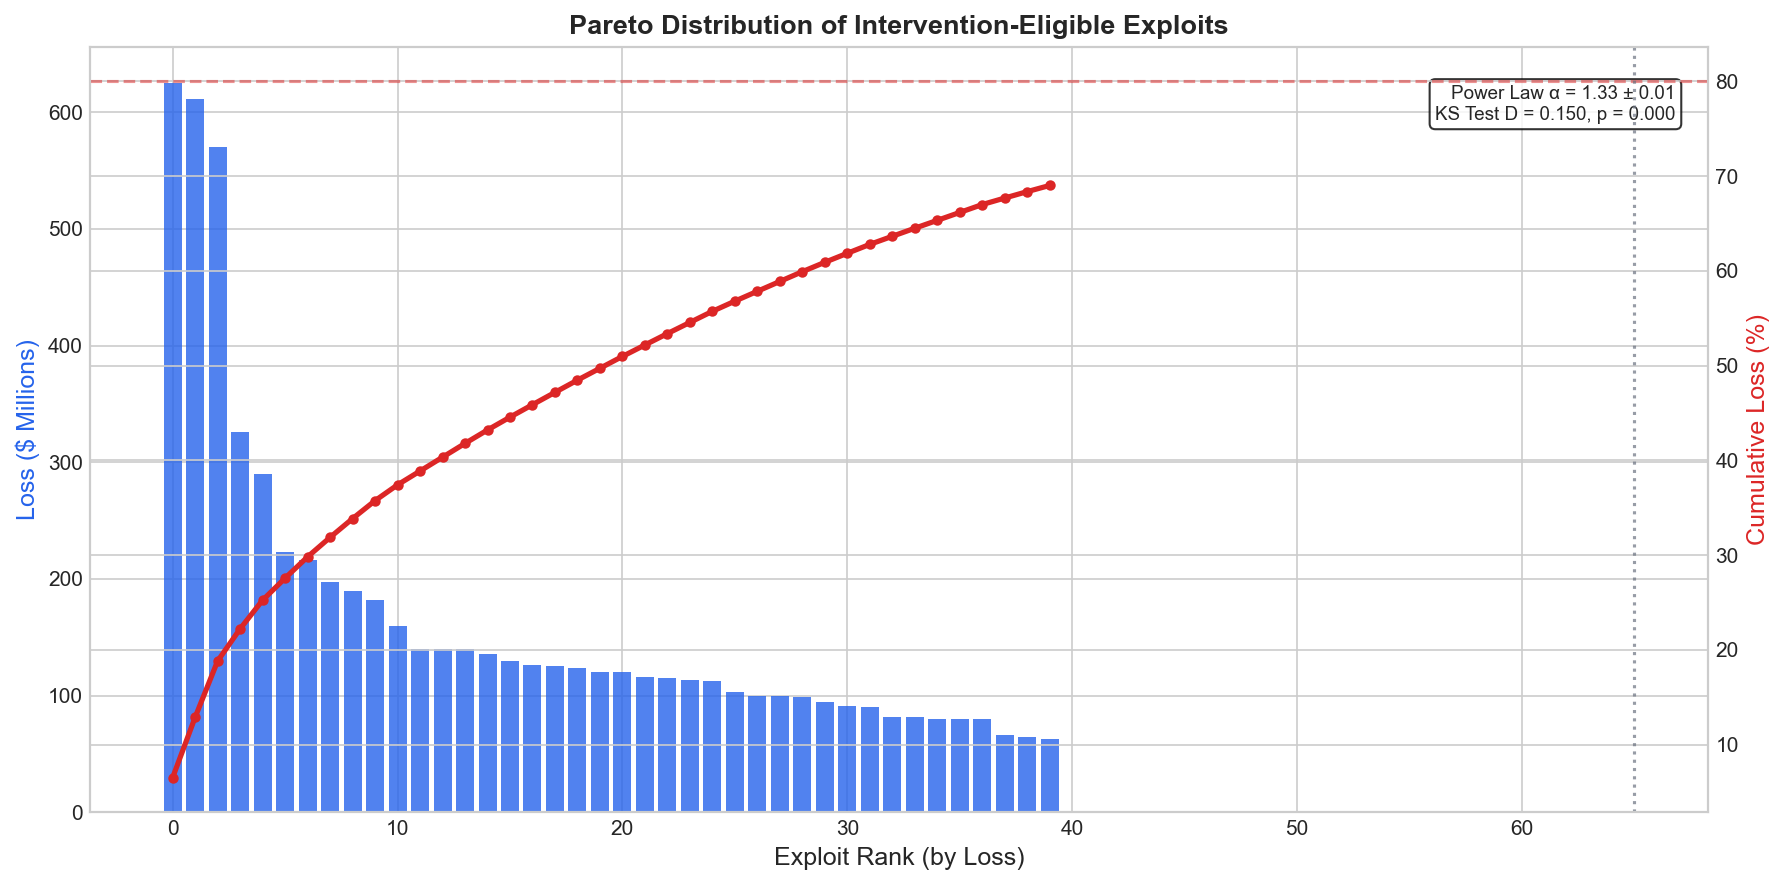

In [40]:
# Figure 1: Pareto Loss Distribution
print("[1/8] Generating Pareto Loss Distribution...")
fig, ax = plt.subplots(figsize=(12, 6))

sorted_losses = intervention_eligible['loss_usd'].dropna().sort_values(ascending=False).reset_index(drop=True)
sorted_losses = sorted_losses[sorted_losses > 0]
cumsum = sorted_losses.cumsum()
total = sorted_losses.sum()
cumulative_pct = (cumsum / total) * 100

alpha, se = fit_power_law(sorted_losses, xmin=sorted_losses.min())
D, p_value = ks_test_power_law(sorted_losses, alpha, sorted_losses.min())

top_n = min(40, len(sorted_losses))
x = np.arange(top_n)

bars = ax.bar(x, sorted_losses.head(top_n) / 1e6, color=COLORS['primary_blue'], alpha=0.8)
ax2 = ax.twinx()
ax2.plot(x, cumulative_pct.head(top_n), color=COLORS['danger_red'], linewidth=2.5, marker='o', markersize=4)
ax2.axhline(y=80, color=COLORS['danger_red'], linestyle='--', alpha=0.5)

pareto_idx = (cumulative_pct >= 80).idxmax()
ax2.axvline(x=pareto_idx, color=COLORS['neutral_gray'], linestyle=':', alpha=0.7)

ax.set_xlabel('Exploit Rank (by Loss)', fontsize=12)
ax.set_ylabel('Loss ($ Millions)', fontsize=12, color=COLORS['primary_blue'])
ax2.set_ylabel('Cumulative Loss (%)', fontsize=12, color=COLORS['danger_red'])
ax.set_title('Pareto Distribution of Intervention-Eligible Exploits', fontsize=13, fontweight='bold')

stats_text = f'Power Law α = {alpha:.2f} ± {se:.2f}\nKS Test D = {D:.3f}, p = {p_value:.3f}'
ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, fontsize=9, va='top', ha='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof01_pareto_loss_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  ✓ Saved {FIGURES_DIR / 'lof01_pareto_loss_distribution.png'}")
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[2/8] Generating Four-Layer Loss Timeline...
  ✓ Saved lof02_four_layer_timeline.png


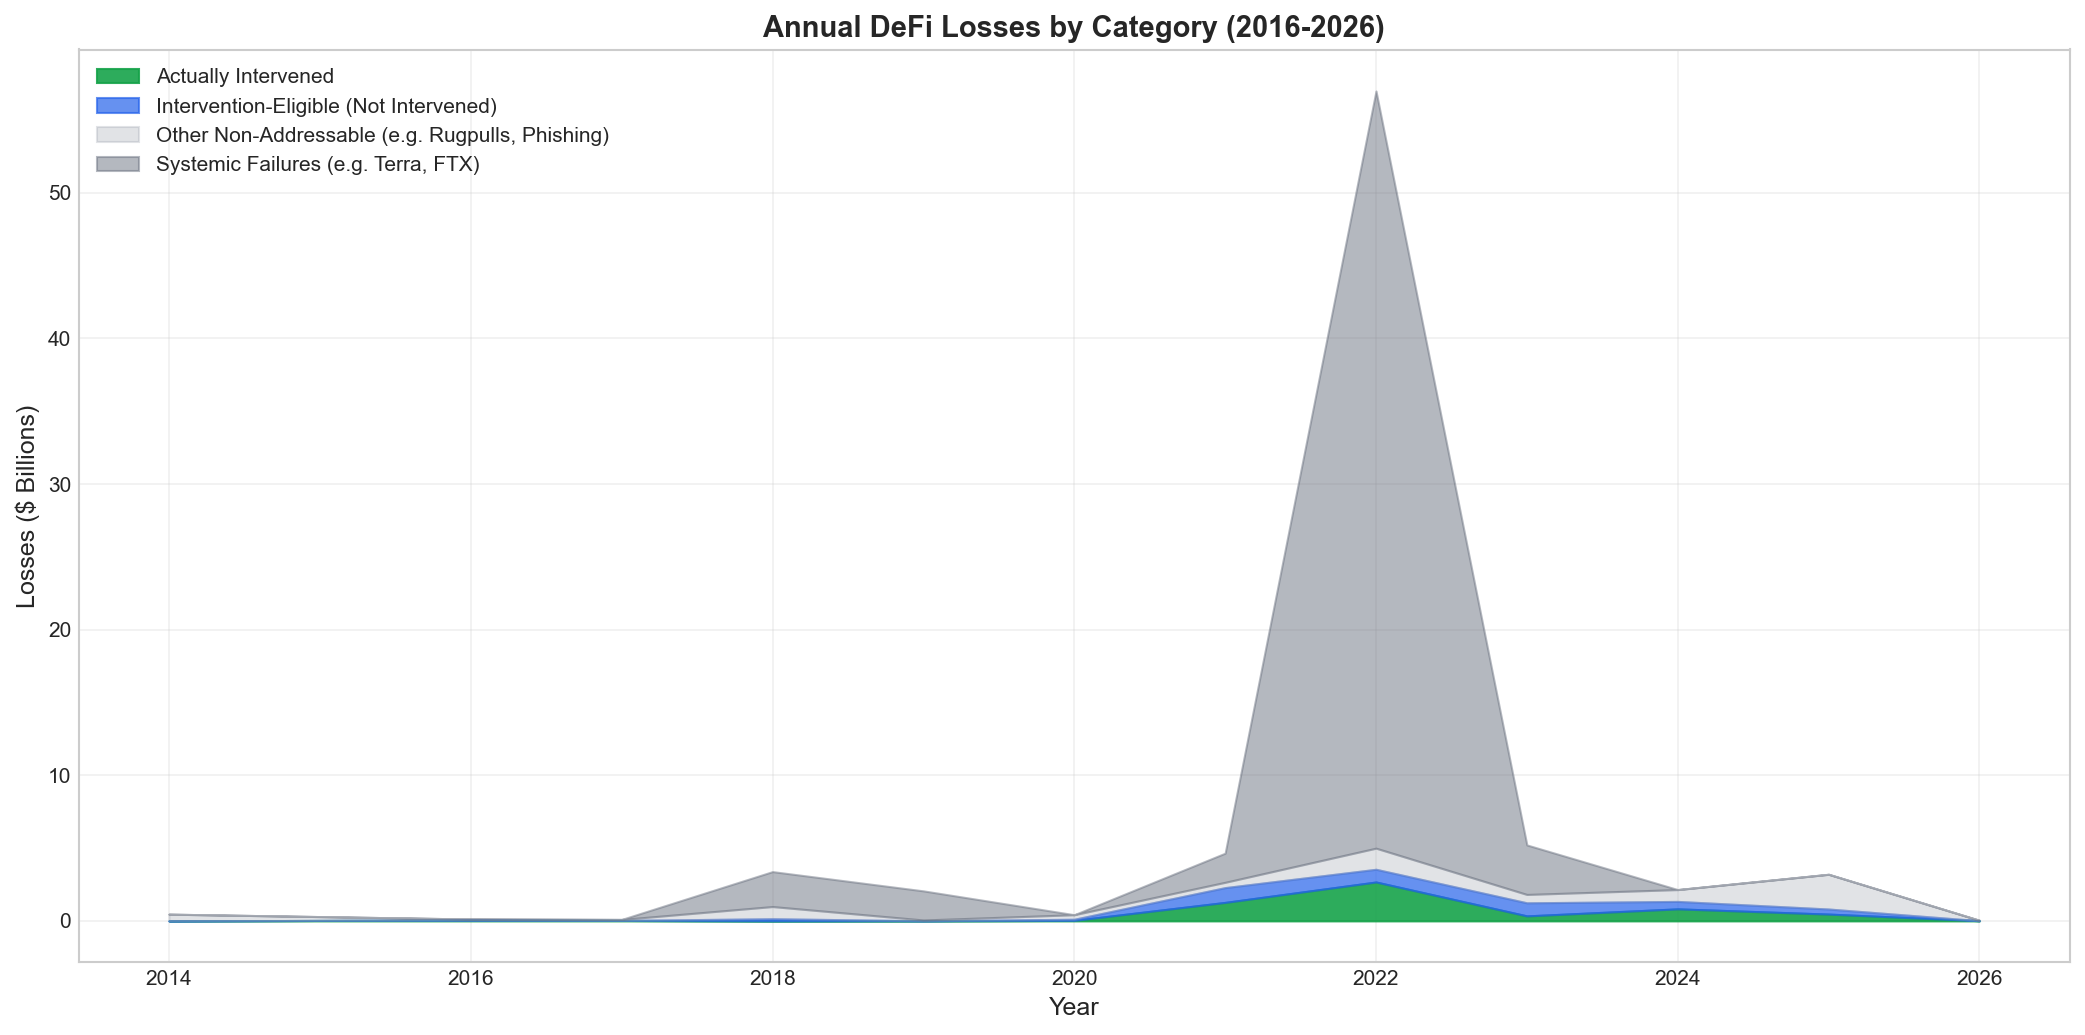

In [41]:
# Figure 2: Four-Layer Timeline 
print("[2/8] Generating Four-Layer Loss Timeline...")
fig, ax = plt.subplots(figsize=(14, 7))

exploits['year'] = exploits['date'].dt.year

# Calculate yearly losses by category
systemic_yearly = systemic_failures.groupby(systemic_failures['date'].dt.year)['loss_usd'].sum() / 1e9
other_yearly = other_non_addressable.groupby(other_non_addressable['date'].dt.year)['loss_usd'].sum() / 1e9
eligible_yearly = intervention_eligible.groupby(intervention_eligible['date'].dt.year)['loss_usd'].sum() / 1e9

# Actually intervened (subset of intervention-eligible)
intervened = intervention_eligible[intervention_eligible['is_intervention'] == True]
intervened_yearly = intervened.groupby(intervened['date'].dt.year)['loss_usd'].sum() / 1e9

# Align years
years = sorted(set(systemic_yearly.index) | set(other_yearly.index) | set(eligible_yearly.index) | set(intervened_yearly.index))
systemic_yearly = systemic_yearly.reindex(years, fill_value=0)
other_yearly = other_yearly.reindex(years, fill_value=0)
eligible_yearly = eligible_yearly.reindex(years, fill_value=0)
intervened_yearly = intervened_yearly.reindex(years, fill_value=0)

# Plot layers (bottom to top)
ax.fill_between(years, 0, intervened_yearly, alpha=0.9, color=COLORS['success_green'], label='Actually Intervened')
ax.fill_between(years, intervened_yearly, eligible_yearly, alpha=0.7, color=COLORS['primary_blue'], label='Intervention-Eligible (Not Intervened)')

totals_l2 = eligible_yearly
totals_l3 = eligible_yearly + other_yearly
ax.fill_between(years, totals_l2, totals_l3, alpha=0.3, color=COLORS['light_gray'], label='Other Non-Addressable (e.g. Rugpulls, Phishing)')

totals_l4 = totals_l3 + systemic_yearly
ax.fill_between(years, totals_l3, totals_l4, alpha=0.5, color=COLORS['neutral_gray'], label='Systemic Failures (e.g. Terra, FTX)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Losses ($ Billions)', fontsize=12)
ax.set_title('Annual DeFi Losses by Category (2016-2026)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', frameon=False)
ax.grid(True, alpha=0.3)

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof02_four_layer_timeline.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  ✓ Saved lof02_four_layer_timeline.png")
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[3/8] Generating Top 10 Intervention-Eligible Exploits...
  ✓ Saved lof03_top_10_exploits.png


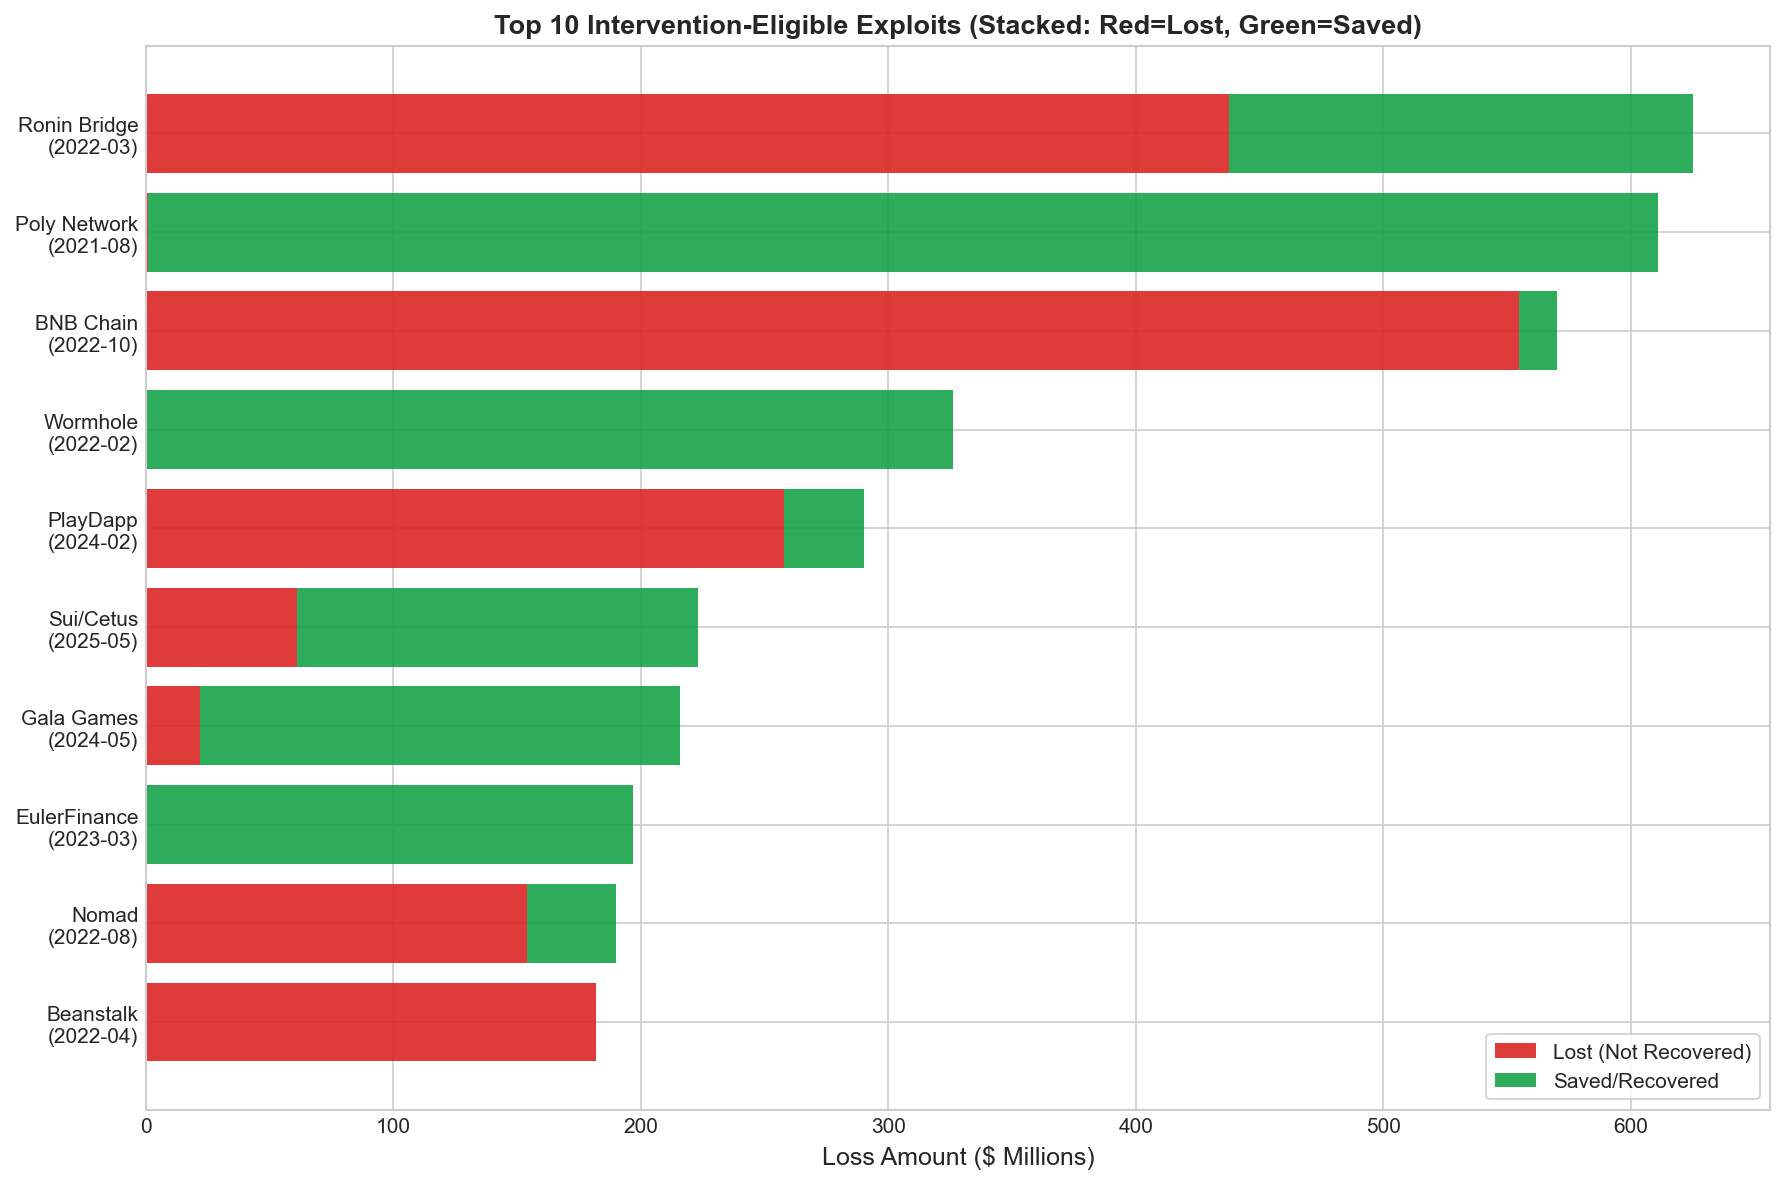

In [42]:
# Figure 3: Top 10 Intervention-Eligible Exploits (Stacked: Green=Saved, Red=Lost)
print("[3/8] Generating Top 10 Intervention-Eligible Exploits...")
fig, ax = plt.subplots(figsize=(12, 8))

# Get top 10 by total loss, including loss_prevented for stacking
top10 = intervention_eligible.nlargest(10, 'loss_usd')[['protocol', 'loss_usd', 'loss_prevented_usd', 'date', 'vector_category', 'is_intervention']].copy()
top10['label'] = top10['protocol'] + '\n(' + top10['date'].dt.strftime('%Y-%m') + ')'

# Ensure loss_prevented_usd is filled (NaN -> 0)
top10['loss_prevented_usd'] = top10['loss_prevented_usd'].fillna(0)

# Calculate actual loss (what was stolen and not recovered)
top10['actual_loss_usd'] = top10['loss_usd'] - top10['loss_prevented_usd']
top10['actual_loss_usd'] = top10['actual_loss_usd'].clip(lower=0)  # Ensure non-negative

# Create stacked horizontal bar chart
y_pos = np.arange(len(top10))

# Bottom layer: Actual loss (red)
bars_lost = ax.barh(y_pos, top10['actual_loss_usd'] / 1e6, 
                    color=COLORS['danger_red'], label='Lost (Not Recovered)', alpha=0.9)

# Top layer: Prevented/Saved (green) - stacked on top of lost
bars_saved = ax.barh(y_pos, top10['loss_prevented_usd'] / 1e6, 
                     left=top10['actual_loss_usd'] / 1e6,
                     color=COLORS['success_green'], label='Saved/Recovered', alpha=0.9)

ax.set_yticks(y_pos)
ax.set_yticklabels(top10['label'])
ax.invert_yaxis()
ax.set_xlabel('Loss Amount ($ Millions)', fontsize=12)
ax.set_title('Top 10 Intervention-Eligible Exploits (Stacked: Red=Lost, Green=Saved)', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', frameon=True, fontsize=10)

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof03_top_10_exploits.png', dpi=300, bbox_inches='tight', facecolor='white')
    print('  ✓ Saved lof03_top_10_exploits.png')
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[4/8] Generating Attack Vector Distribution...
  ✓ Saved lof04_attack_vector_distribution.png


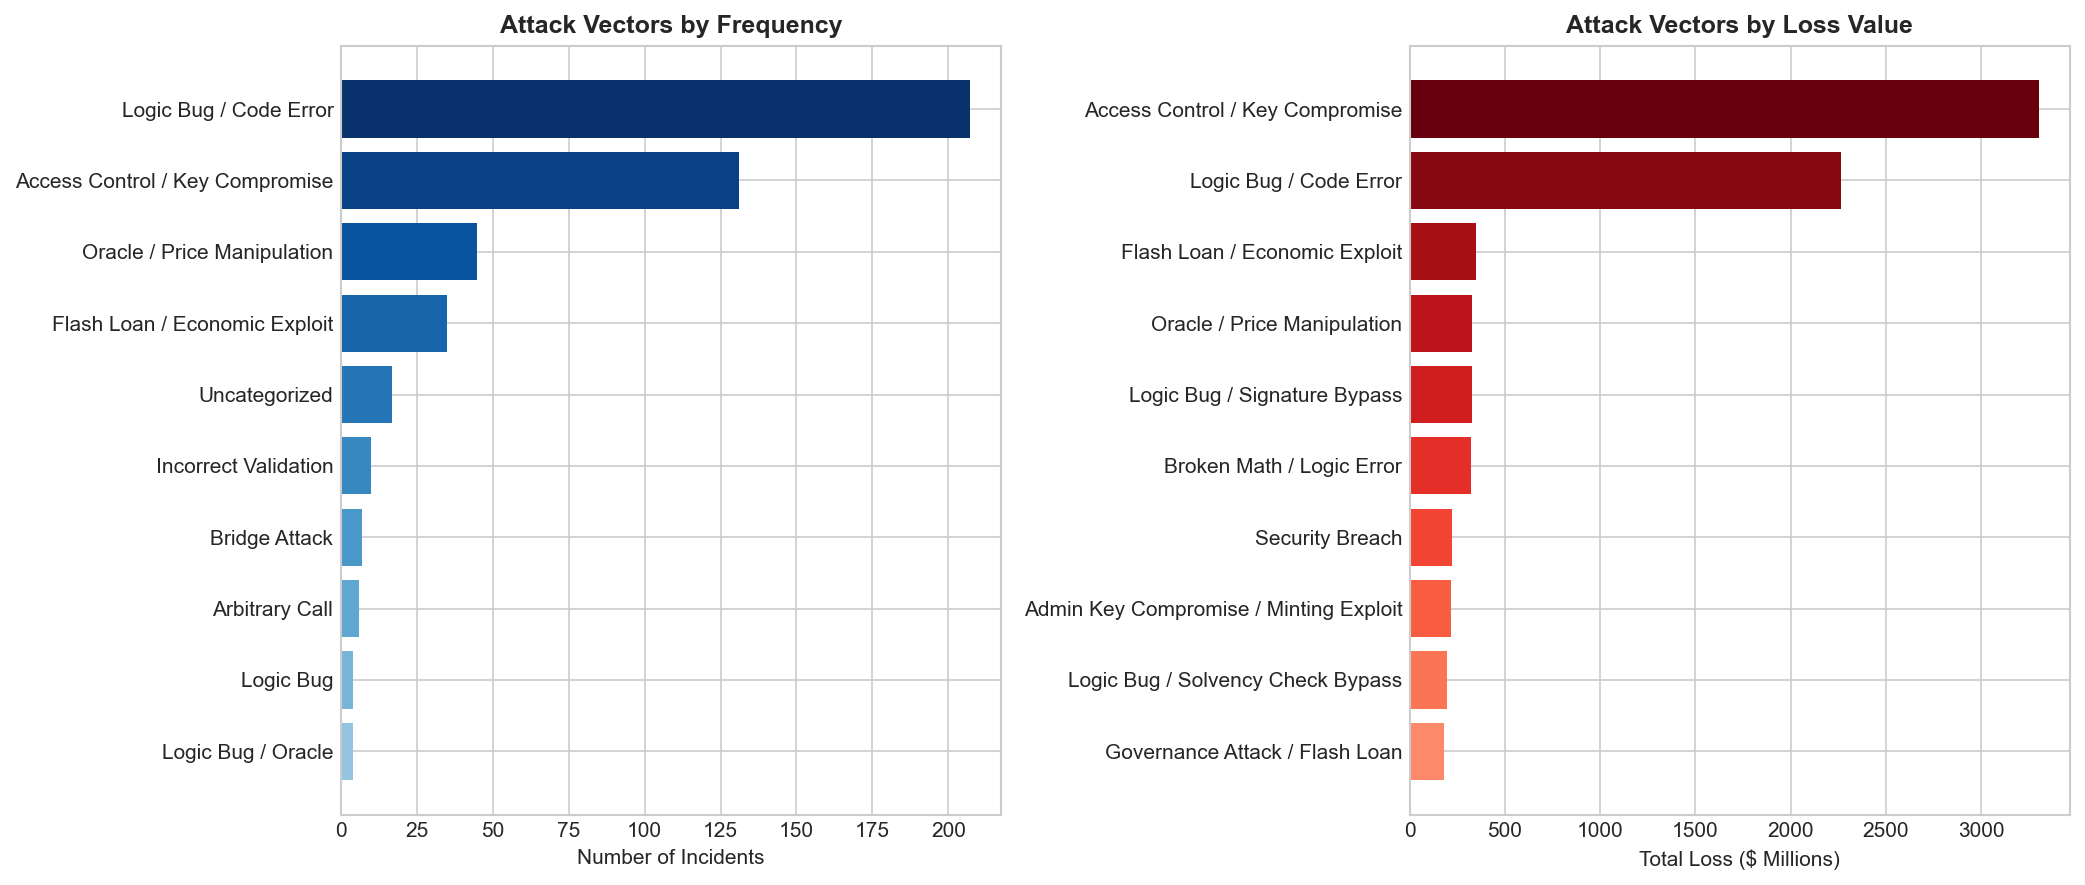

In [43]:
# Figure 4: Attack Vector Distribution
print("[4/8] Generating Attack Vector Distribution...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
vector_counts = intervention_eligible['vector_category'].value_counts().head(10)
colors1 = plt.cm.Blues(np.linspace(0.4, 1, len(vector_counts)))[::-1]
axes[0].barh(range(len(vector_counts)), vector_counts.values, color=colors1)
axes[0].set_yticks(range(len(vector_counts)))
axes[0].set_yticklabels(vector_counts.index)
axes[0].invert_yaxis()
axes[0].set_xlabel('Number of Incidents')
axes[0].set_title('Attack Vectors by Frequency', fontweight='bold')
vector_value = intervention_eligible.groupby('vector_category')['loss_usd'].sum().sort_values(ascending=False).head(10) / 1e6
colors2 = plt.cm.Reds(np.linspace(0.4, 1, len(vector_value)))[::-1]
axes[1].barh(range(len(vector_value)), vector_value.values, color=colors2)
axes[1].set_yticks(range(len(vector_value)))
axes[1].set_yticklabels(vector_value.index)
axes[1].invert_yaxis()
axes[1].set_xlabel('Total Loss ($ Millions)')
axes[1].set_title('Attack Vectors by Loss Value', fontweight='bold')
plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof04_attack_vector_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
    print('  ✓ Saved lof04_attack_vector_distribution.png')
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[5/8] Generating Intervention Effectiveness...
  ✓ Saved lof05_intervention_effectiveness.png


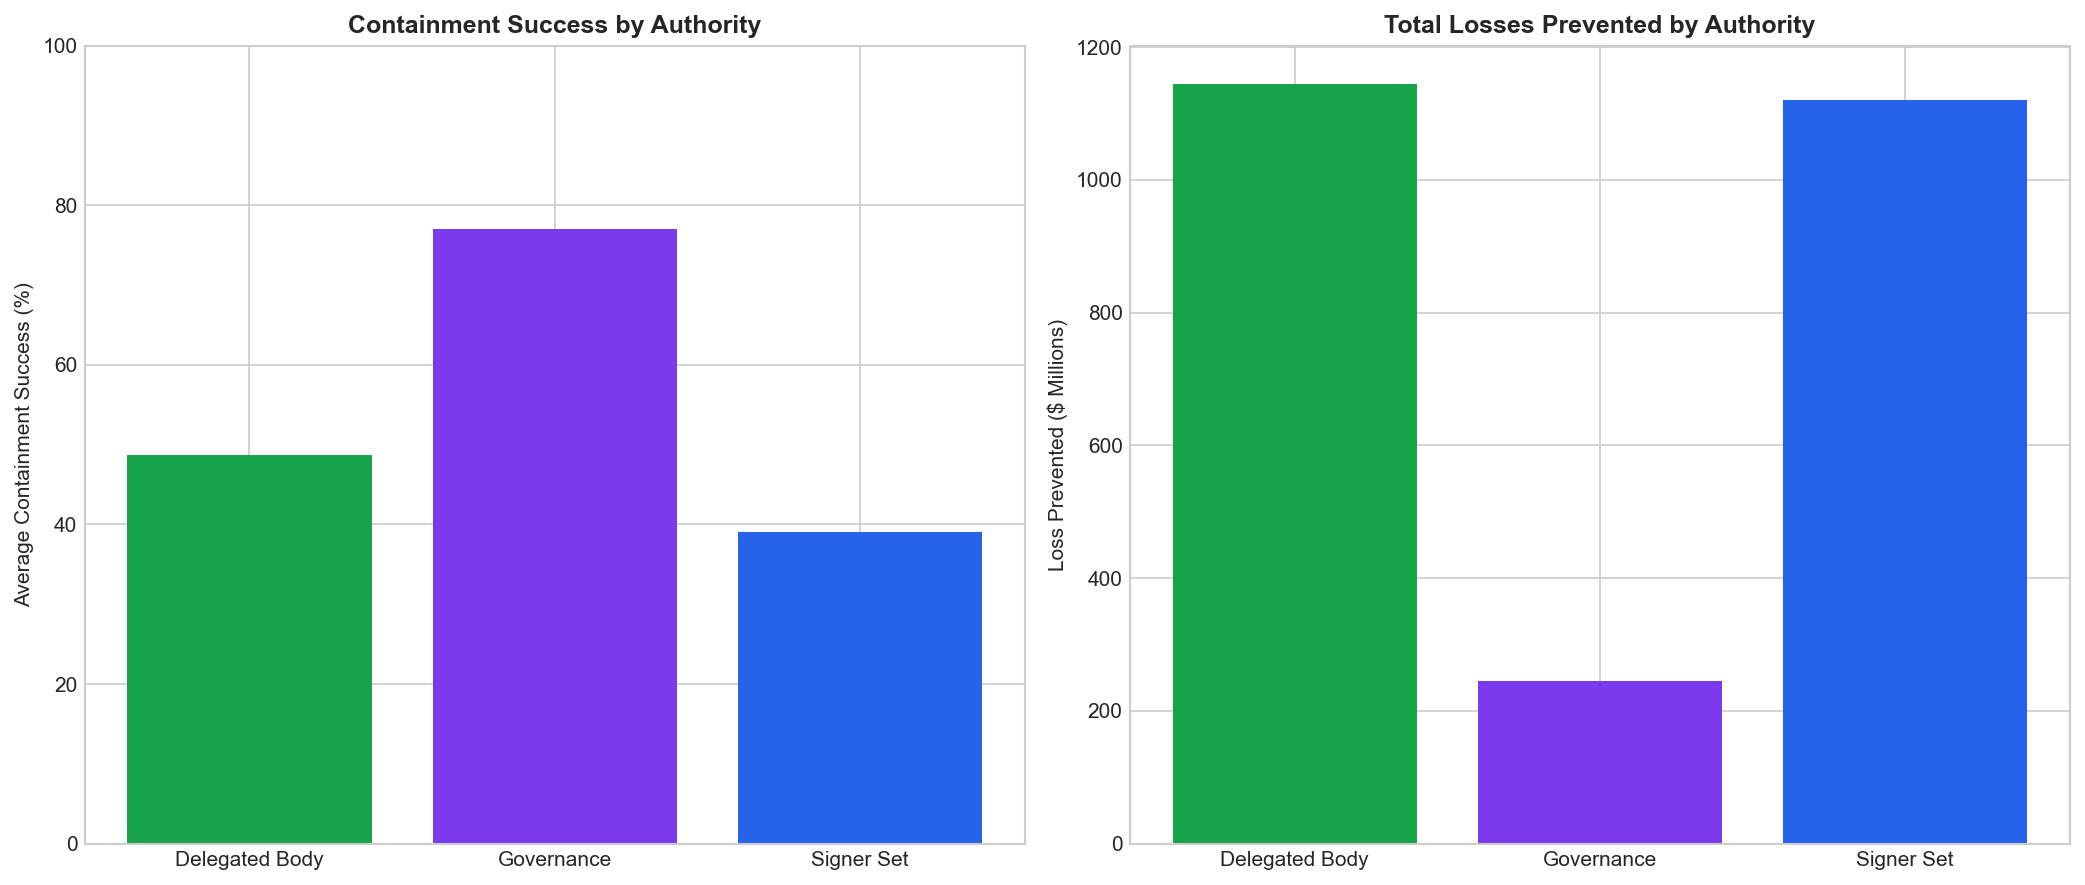

In [44]:
# Figure 5: Intervention Effectiveness
print("[5/8] Generating Intervention Effectiveness...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
auth_success = metrics.groupby('authority')['containment_success_pct'].mean()
colors = [AUTHORITY_COLORS.get(a, COLORS['neutral_gray']) for a in auth_success.index]
axes[0].bar(range(len(auth_success)), auth_success.values, color=colors)
axes[0].set_xticks(range(len(auth_success)))
axes[0].set_xticklabels(auth_success.index)
axes[0].set_ylabel('Average Containment Success (%)')
axes[0].set_title('Containment Success by Authority', fontweight='bold')
axes[0].set_ylim(0, 100)
auth_prevented = interventions.groupby('authority')['loss_prevented_usd'].sum().dropna() / 1e6
auth_prevented = auth_prevented[auth_prevented > 0]
colors = [AUTHORITY_COLORS.get(a, COLORS['neutral_gray']) for a in auth_prevented.index]
axes[1].bar(range(len(auth_prevented)), auth_prevented.values, color=colors)
axes[1].set_xticks(range(len(auth_prevented)))
axes[1].set_xticklabels(auth_prevented.index)
axes[1].set_ylabel('Loss Prevented ($ Millions)')
axes[1].set_title('Total Losses Prevented by Authority', fontweight='bold')
plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof05_intervention_effectiveness.png', dpi=300, bbox_inches='tight', facecolor='white')
    print('  ✓ Saved lof05_intervention_effectiveness.png')
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[6/8] Generating Authority Distribution...
  ✓ Saved lof06_authority_distribution.png


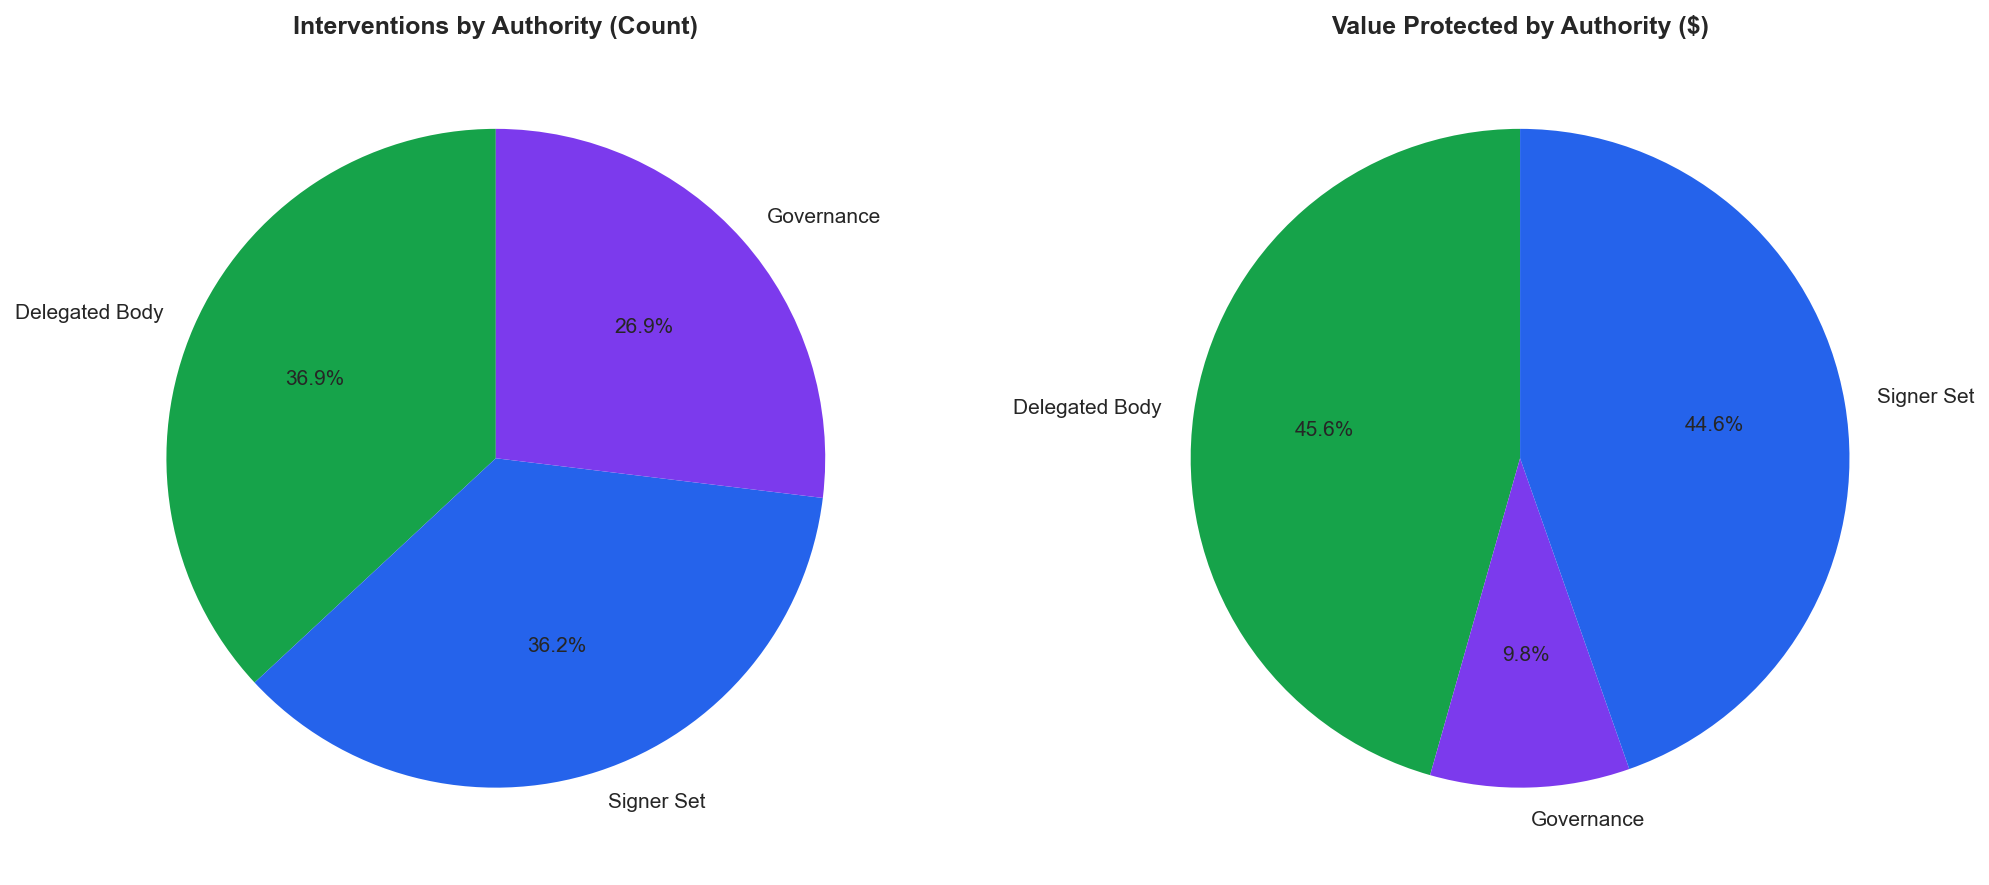

In [45]:
# Figure 6: Authority Distribution
print("[6/8] Generating Authority Distribution...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
auth_counts = interventions['authority'].value_counts()
colors = [AUTHORITY_COLORS.get(a, COLORS['neutral_gray']) for a in auth_counts.index]
axes[0].pie(auth_counts.values, labels=auth_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Interventions by Authority (Count)', fontweight='bold')
auth_value = interventions.groupby('authority')['loss_prevented_usd'].sum()
auth_value = auth_value[auth_value > 0]
colors = [AUTHORITY_COLORS.get(a, COLORS['neutral_gray']) for a in auth_value.index]
axes[1].pie(auth_value.values, labels=auth_value.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Value Protected by Authority ($)', fontweight='bold')
plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof06_authority_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
    print('  ✓ Saved lof06_authority_distribution.png')
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[7/8] Generating Scope × Authority Matrix...
  ✓ Saved lof07_scope_authority_matrix.png


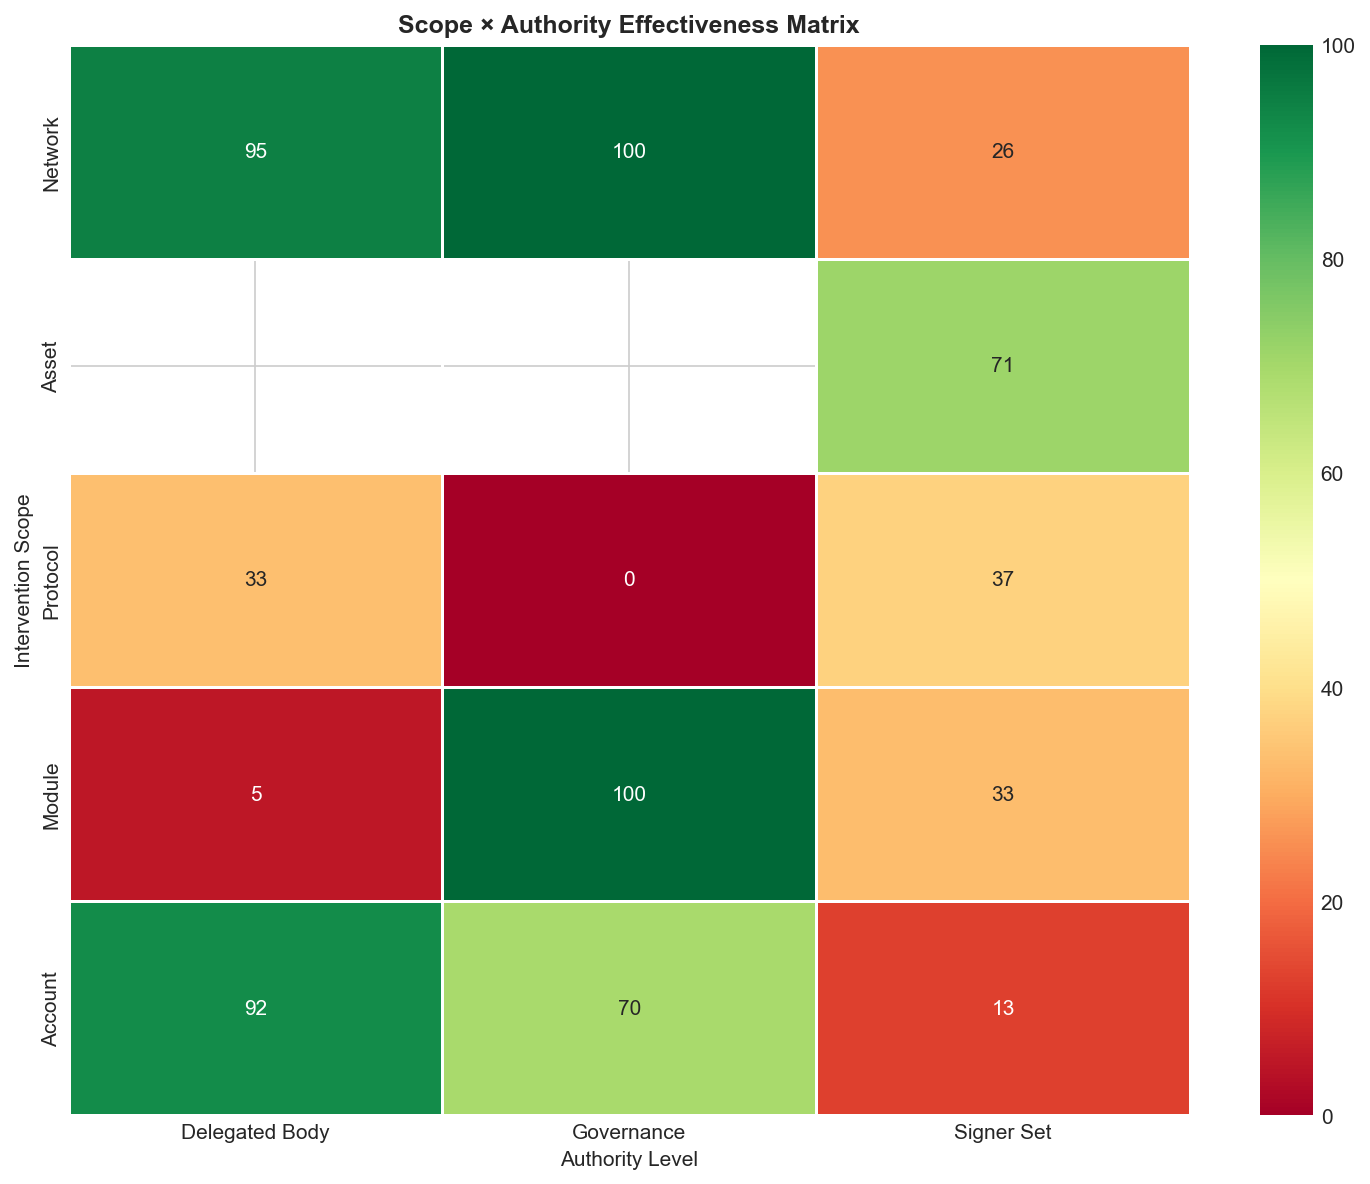

In [46]:
# Figure 7: Scope × Authority Matrix
print("[7/8] Generating Scope × Authority Matrix...")
fig, ax = plt.subplots(figsize=(10, 8))
pivot = pd.pivot_table(metrics, values='containment_success_pct', index='scope', columns='authority', aggfunc='mean', fill_value=np.nan)
scope_order = ['Network', 'Asset', 'Protocol', 'Module', 'Account']
pivot = pivot.reindex([s for s in scope_order if s in pivot.index])
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='RdYlGn', center=50, ax=ax, linewidths=0.5, mask=pivot.isna())
ax.set_title('Scope × Authority Effectiveness Matrix', fontweight='bold')
ax.set_xlabel('Authority Level')
ax.set_ylabel('Intervention Scope')
plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof07_scope_authority_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
    print('  ✓ Saved lof07_scope_authority_matrix.png')
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)

[8/8] Generating Containment Time Analysis...
  ✓ Saved lof08_containment_time_analysis.png


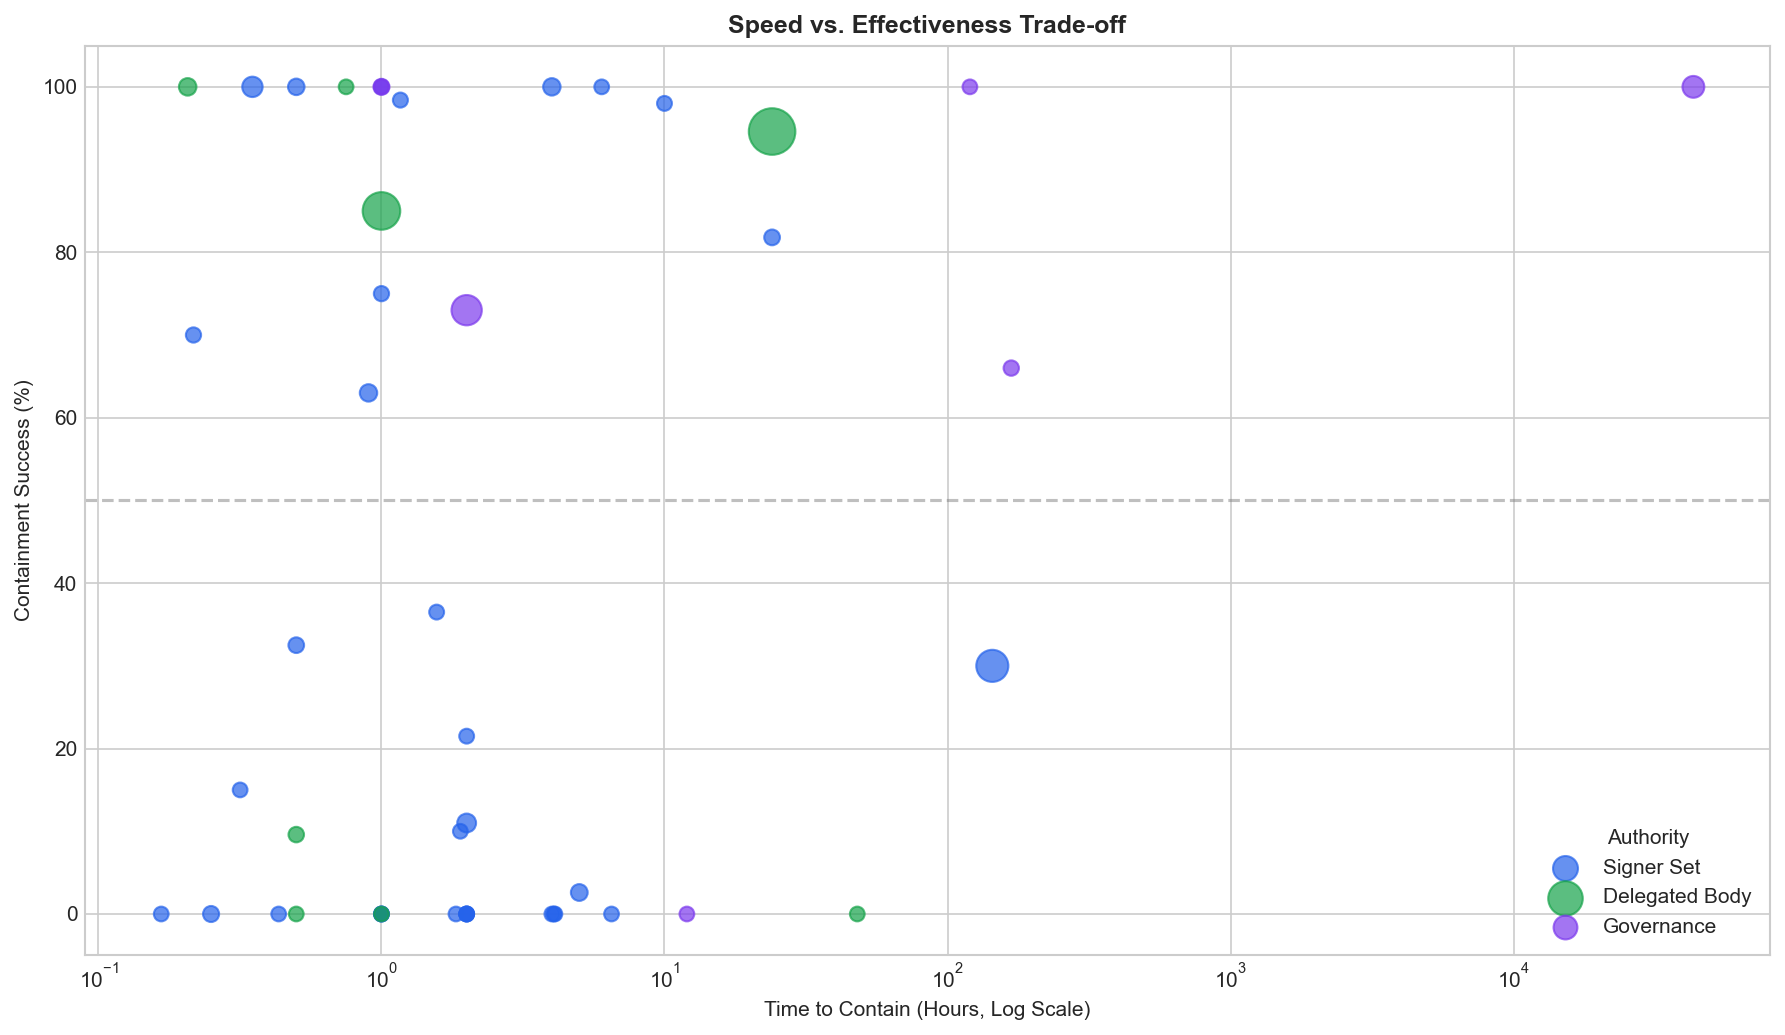


✓ All 8 figures generated!


In [47]:
# Figure 8: Containment Time Analysis
print("[8/8] Generating Containment Time Analysis...")
fig, ax = plt.subplots(figsize=(12, 7))
df_time = metrics[metrics['time_to_contain_min'] > 0].copy()
df_time['time_hours'] = df_time['time_to_contain_min'] / 60
for authority in ['Signer Set', 'Delegated Body', 'Governance']:
    subset = df_time[df_time['authority'] == authority]
    if len(subset) == 0:
        continue
    color = AUTHORITY_COLORS.get(authority, COLORS['neutral_gray'])
    size = np.clip(subset['loss_prevented_usd'].fillna(0) / 1e6 + 50, 50, 500)
    ax.scatter(subset['time_hours'], subset['containment_success_pct'], s=size, c=color, alpha=0.7, label=authority)
ax.set_xlabel('Time to Contain (Hours, Log Scale)')
ax.set_ylabel('Containment Success (%)')
ax.set_title('Speed vs. Effectiveness Trade-off', fontweight='bold')
ax.set_xscale('log')
ax.legend(title='Authority', loc='lower right')
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(-5, 105)
plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIGURES_DIR / 'lof08_containment_time_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
    print('  ✓ Saved lof08_containment_time_analysis.png')
if SHOW_FIGURES_INLINE:
    plt.show()
else:
    plt.close(fig)
print('\n✓ All 8 figures generated!')

In [53]:
# Speed-Scope-Success Paradox Analysis
print("Analyzing Speed-Scope-Success Paradox...")

# Calculate comprehensive metrics for 52 verified cases
paradox_data = []

for authority in ['Signer Set', 'Delegated Body', 'Governance']:
    # Filter out Ethereum DAO hack (2016) as it skews governance timing data
    subset = metrics[
        (metrics['authority'] == authority) & 
        (metrics['date'].dt.year != 2016)
    ]
    
    # Basic stats
    case_count = len(subset)
    success_rate = subset['containment_success_pct'].mean()
    avg_time_hours = subset['time_to_contain_min'].mean() / 60 if len(subset) > 0 else 0
    
    # Value metrics
    value_protected_b = subset['loss_prevented_usd'].sum() / 1e9
    value_protected_pct = (value_protected_b / metrics['loss_prevented_usd'].sum() / 1e9) * 100
    
    # Scope distribution
    scope_dist = subset['scope'].value_counts().to_dict()
    network_scope_pct = (scope_dist.get('Network', 0) / case_count) * 100 if case_count > 0 else 0
    
    paradox_data.append({
        'Authority': authority,
        'Political_Analogy': 'Oligarchy' if authority == 'Signer Set' else 
                         'Representative Democracy' if authority == 'Delegated Body' else 
                         'Direct Democracy',
        'Case_Count': case_count,
        'Case_Percentage': (case_count / len(metrics)) * 100,
        'Success_Rate': success_rate,
        'Avg_Time_Hours': avg_time_hours,
        'Value_Protected_B': value_protected_b,
        'Value_Protected_Percentage': value_protected_pct,
        'Network_Scope_Percentage': network_scope_pct
    })

paradox_df = pd.DataFrame(paradox_data)

print("="*60)
print("SPEED-SCOPE-SUCCESS PARADOX ANALYSIS")
print("="*60)
for _, row in paradox_df.iterrows():
    print(f"\n- {row['Authority']} ({row['Political_Analogy']}):")
    print(f"   Cases: {row['Case_Count']} ({row['Case_Percentage']:.1f}% of total)")
    print(f"   Success Rate: {row['Success_Rate']:.1f}%")
    print(f"   Avg Response Time: {row['Avg_Time_Hours']:.1f} hours")
    print(f"   Value Protected: ${row['Value_Protected_B']:.2f}B ({row['Value_Protected_Percentage']:.1f}%)")
    print(f"   Network Scope Cases: {row['Network_Scope_Percentage']:.1f}%")

Analyzing Speed-Scope-Success Paradox...
SPEED-SCOPE-SUCCESS PARADOX ANALYSIS

- Signer Set (Oligarchy):
   Cases: 37 (71.2% of total)
   Success Rate: 39.1%
   Avg Response Time: 6.5 hours
   Value Protected: $0.55B (0.0%)
   Network Scope Cases: 10.8%

- Delegated Body (Representative Democracy):
   Cases: 8 (15.4% of total)
   Success Rate: 48.6%
   Avg Response Time: 9.5 hours
   Value Protected: $0.88B (0.0%)
   Network Scope Cases: 12.5%

- Governance (Direct Democracy):
   Cases: 6 (11.5% of total)
   Success Rate: 73.2%
   Avg Response Time: 50.7 hours
   Value Protected: $0.18B (0.0%)
   Network Scope Cases: 16.7%


---
# Summary Statistics
---

In [51]:
print("="*60)
print("KEY STATISTICS FOR PAPER")
print("="*60)
print(f"Total exploits: {len(exploits)}")
print(f"  - Intervention-eligible: {len(intervention_eligible)} (${intervention_eligible['loss_usd'].sum()/1e9:.2f}B)")
print(f"  - Systemic Failures: {len(systemic_failures)} (${systemic_failures['loss_usd'].sum()/1e9:.2f}B)")
print(f"  - Other Non-Addressable: {len(other_non_addressable)} (${other_non_addressable['loss_usd'].sum()/1e9:.2f}B)")
print(f"Interventions (all): {len(interventions)}")
print(f"High-fidelity Metrics (curated): {len(metrics)}")
print(f"Power law exponent: α = {alpha:.2f} ± {se:.2f}")
print(f"KS test p-value: {p_value:.3f}")
if 'avg_sentiment' in dir():
    print(f"Average sentiment: {avg_sentiment:.3f}")
print("\n✓ Analysis complete!")

KEY STATISTICS FOR PAPER
Total exploits: 705
  - Intervention-eligible: 601 ($9.60B)
  - Systemic Failures: 10 ($61.80B)
  - Other Non-Addressable: 94 ($7.41B)
Interventions (all): 130
High-fidelity Metrics (curated): 52
Power law exponent: α = 1.33 ± 0.01
KS test p-value: 0.000

✓ Analysis complete!
